## Getting Started

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install numpy==1.23.5
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from official import nlp
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

In [4]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

## Data and Modeling

In [6]:
def data_process(name):
  dataset = pd.read_csv('/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/dataset/train_data.csv')
  if name == 'MultiPlatform':
        data = dataset.sample(frac=1, random_state=42)
        data.reset_index(inplace=True, drop=True)
  else:
    data_pf = dataset[dataset.platform==name]
    data = data_pf.sample(frac=1, random_state=42)
    data.reset_index(inplace=True, drop=True)
    
  X_train, Xval_test, y_train, y_valtest = train_test_split(data['comments'],data['sentiment'], stratify=data['sentiment'], test_size=0.2)
  valx, testx, valy, testy = train_test_split(Xval_test, y_valtest, test_size=0.5)  
  return X_train, valx, testx, y_train, valy, testy


In [7]:
def build_classifier_model():
  bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
  tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
  tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
  
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [8]:
def train_evaluate_model(name):
  # load dataset
  X_train, valx, testx, y_train, valy, testy = data_process(name)
  
  # load the model
  classifier_model = build_classifier_model()
  
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  metrics = tf.metrics.BinaryAccuracy()
  # Set up epochs and steps
  epochs = 20
  batch_size = 32
  eval_batch_size = 32

  train_data_size = len(y_train)
  steps_per_epoch = int(train_data_size / batch_size)
  num_train_steps = steps_per_epoch * epochs
  warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)


  # creates an optimizer with learning rate schedule
  optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
  
  # handling overfitting
  earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

  # compile model
  classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
  
  # training model
  history = classifier_model.fit(X_train, y_train,
        validation_data=(valx, valy),
        batch_size=32,
        epochs=epochs,
        callbacks=[earlystopping],
        verbose=1,)

  
  # plot training and validation accuracy
  history_dict = history.history
  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  epochs = range(1, len(acc) + 1)
  fig = plt.figure(figsize=(10, 6))
  fig.tight_layout()

  plt.subplot(2, 1, 1)
  # r is for "solid red line"
  plt.plot(epochs, loss, 'r', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss: '+ name)
  # plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy: '+ name)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.savefig('/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/figures/train_val_acc_' + name + '.png')


  # saving model
  saved_model_path = '/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/models/small_bert/'+name
  classifier_model.save(saved_model_path, include_optimizer=False)

  # evaluate model and save report
  predict = classifier_model.predict(testx)
  pred = []
  for p in predict:
    if p >= 0.5:
      pred.append(1)
    else:
      pred.append(0)
  print(classification_report(testy, pred, target_names=['positive', 'Negative']))
  report = classification_report(testy, pred, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  report_df.to_csv('/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/reports/'+ name+ '.csv')


## Facebook Model

Epoch 1/20
1502/1502 [==============================] - 398s 256ms/step - loss: 0.4581 - binary_accuracy: 0.7706 - val_loss: 0.3189 - val_binary_accuracy: 0.8633
Epoch 2/20
1502/1502 [==============================] - 383s 255ms/step - loss: 0.2959 - binary_accuracy: 0.8757 - val_loss: 0.2589 - val_binary_accuracy: 0.8954
Epoch 3/20
1502/1502 [==============================] - 386s 257ms/step - loss: 0.2334 - binary_accuracy: 0.9057 - val_loss: 0.2332 - val_binary_accuracy: 0.9079
Epoch 4/20
1502/1502 [==============================] - 390s 260ms/step - loss: 0.1863 - binary_accuracy: 0.9264 - val_loss: 0.2317 - val_binary_accuracy: 0.9107
Epoch 5/20
1502/1502 [==============================] - 385s 256ms/step - loss: 0.1487 - binary_accuracy: 0.9421 - val_loss: 0.2651 - val_binary_accuracy: 0.8963
Epoch 6/20
1502/1502 [==============================] - 384s 256ms/step - loss: 0.1194 - binary_accuracy: 0.9561 - val_loss: 0.2854 - val_binary_accuracy: 0.9137
Epoch 7/20
1502/1502 [======

              precision    recall  f1-score   support

    positive       0.90      0.93      0.92      3247
    Negative       0.92      0.88      0.90      2758

    accuracy                           0.91      6005
   macro avg       0.91      0.91      0.91      6005
weighted avg       0.91      0.91      0.91      6005



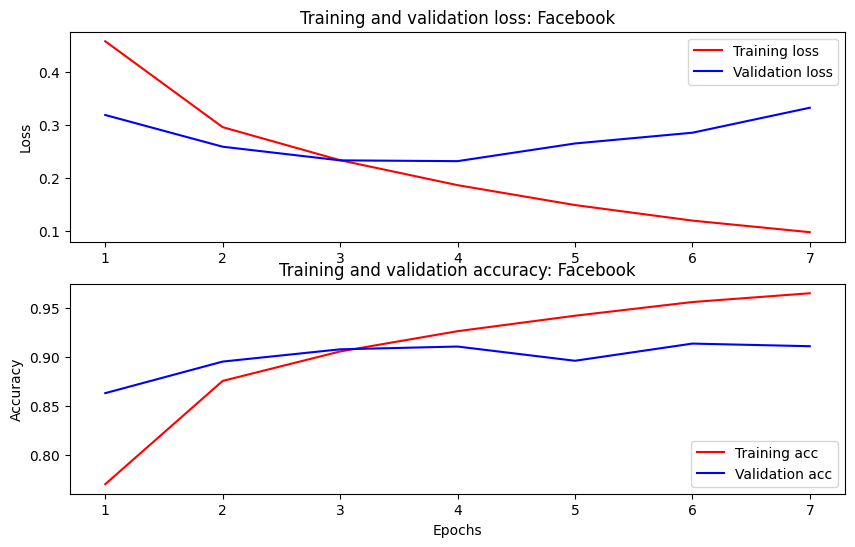

In [ ]:
train_evaluate_model('Facebook')

## Twitter Model

Epoch 1/20
827/827 [==============================] - 217s 253ms/step - loss: 0.4698 - binary_accuracy: 0.7813 - val_loss: 0.3121 - val_binary_accuracy: 0.8757
Epoch 2/20
827/827 [==============================] - 207s 251ms/step - loss: 0.2563 - binary_accuracy: 0.8935 - val_loss: 0.2617 - val_binary_accuracy: 0.8996
Epoch 3/20
827/827 [==============================] - 206s 250ms/step - loss: 0.1975 - binary_accuracy: 0.9201 - val_loss: 0.2094 - val_binary_accuracy: 0.9171
Epoch 4/20
827/827 [==============================] - 206s 249ms/step - loss: 0.1589 - binary_accuracy: 0.9376 - val_loss: 0.2296 - val_binary_accuracy: 0.9202
Epoch 5/20
827/827 [==============================] - 206s 249ms/step - loss: 0.1195 - binary_accuracy: 0.9545 - val_loss: 0.2890 - val_binary_accuracy: 0.9181
Epoch 6/20
827/827 [==============================] - 206s 249ms/step - loss: 0.0939 - binary_accuracy: 0.9675 - val_loss: 0.3240 - val_binary_accuracy: 0.9199
Epoch 6: early stopping


              precision    recall  f1-score   support

    positive       0.94      0.96      0.95      2365
    Negative       0.89      0.84      0.87       943

    accuracy                           0.93      3308
   macro avg       0.91      0.90      0.91      3308
weighted avg       0.92      0.93      0.92      3308



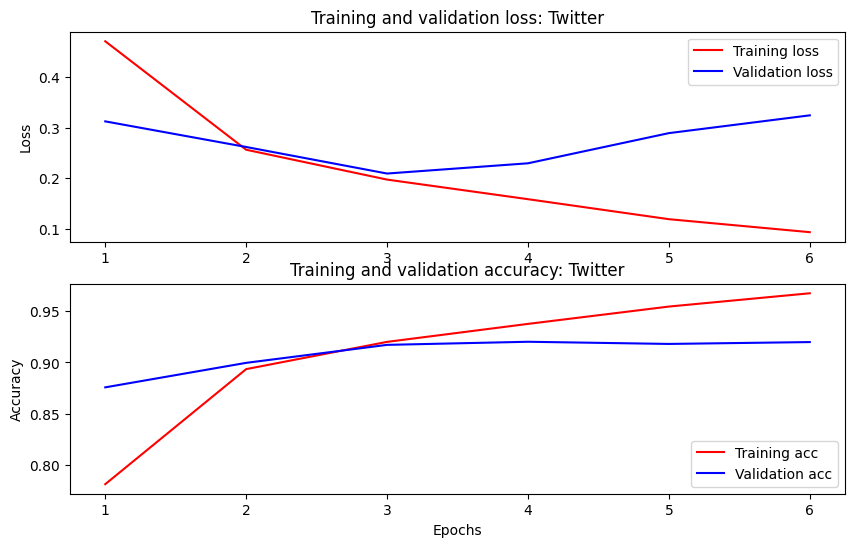

In [ ]:
train_evaluate_model('Twitter')

## Reddit Model

Epoch 1/20
2016/2016 [==============================] - 536s 262ms/step - loss: 0.3378 - binary_accuracy: 0.8308 - val_loss: 0.1626 - val_binary_accuracy: 0.9321
Epoch 2/20
2016/2016 [==============================] - 522s 259ms/step - loss: 0.1476 - binary_accuracy: 0.9426 - val_loss: 0.1375 - val_binary_accuracy: 0.9527
Epoch 3/20
2016/2016 [==============================] - 525s 260ms/step - loss: 0.1114 - binary_accuracy: 0.9587 - val_loss: 0.1254 - val_binary_accuracy: 0.9552
Epoch 4/20
2016/2016 [==============================] - 526s 261ms/step - loss: 0.0878 - binary_accuracy: 0.9697 - val_loss: 0.1486 - val_binary_accuracy: 0.9579
Epoch 5/20
2016/2016 [==============================] - 528s 262ms/step - loss: 0.0680 - binary_accuracy: 0.9782 - val_loss: 0.1640 - val_binary_accuracy: 0.9566
Epoch 6/20
2016/2016 [==============================] - 527s 261ms/step - loss: 0.0518 - binary_accuracy: 0.9849 - val_loss: 0.2182 - val_binary_accuracy: 0.9536
Epoch 6: early stopping


              precision    recall  f1-score   support

    positive       0.97      0.94      0.96      3994
    Negative       0.94      0.98      0.96      4067

    accuracy                           0.96      8061
   macro avg       0.96      0.96      0.96      8061
weighted avg       0.96      0.96      0.96      8061



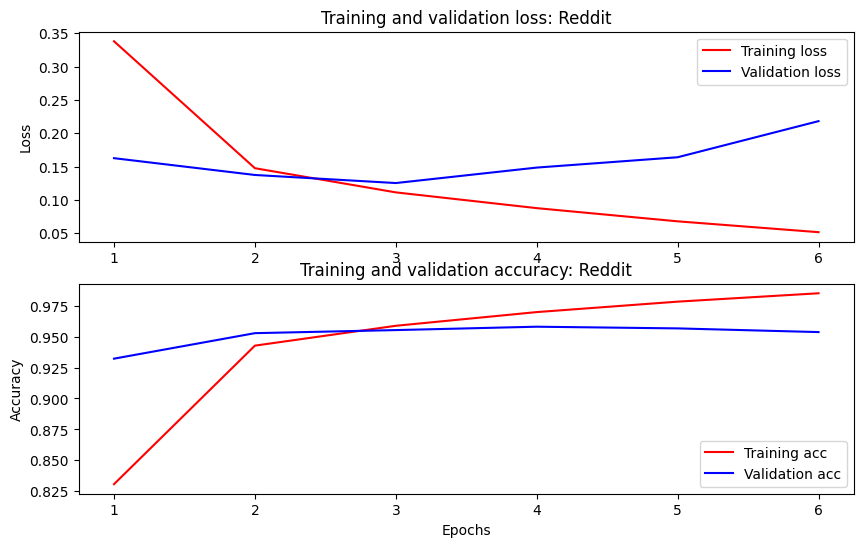

In [ ]:
train_evaluate_model('Reddit')

## Multi-Model

Epoch 1/20
4343/4343 [==============================] - 1117s 255ms/step - loss: 0.4508 - binary_accuracy: 0.7741 - val_loss: 0.2750 - val_binary_accuracy: 0.8857
Epoch 2/20
4343/4343 [==============================] - 1100s 253ms/step - loss: 0.2604 - binary_accuracy: 0.8918 - val_loss: 0.2143 - val_binary_accuracy: 0.9181
Epoch 3/20
4343/4343 [==============================] - 1097s 252ms/step - loss: 0.1981 - binary_accuracy: 0.9213 - val_loss: 0.2019 - val_binary_accuracy: 0.9247
Epoch 4/20
4343/4343 [==============================] - 1097s 253ms/step - loss: 0.1577 - binary_accuracy: 0.9390 - val_loss: 0.1967 - val_binary_accuracy: 0.9280
Epoch 5/20
4343/4343 [==============================] - 1100s 253ms/step - loss: 0.1261 - binary_accuracy: 0.9533 - val_loss: 0.2391 - val_binary_accuracy: 0.9245
Epoch 6/20
4343/4343 [==============================] - 1106s 255ms/step - loss: 0.1016 - binary_accuracy: 0.9646 - val_loss: 0.2909 - val_binary_accuracy: 0.9257
Epoch 7/20
4343/4343 [

              precision    recall  f1-score   support

    positive       0.93      0.94      0.94      9610
    Negative       0.93      0.91      0.92      7762

    accuracy                           0.93     17372
   macro avg       0.93      0.93      0.93     17372
weighted avg       0.93      0.93      0.93     17372



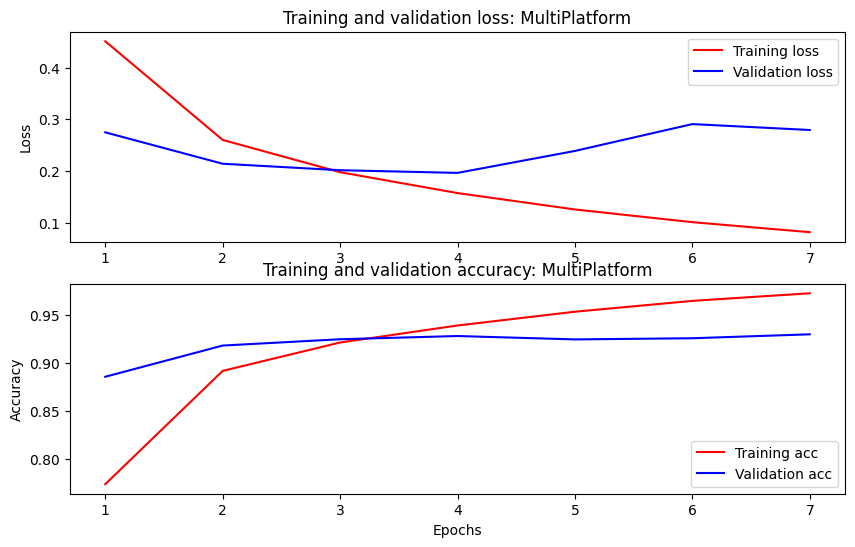

In [ ]:
train_evaluate_model('MultiPlatform')

## Cross Platform Performance

In [ ]:
def cross_performance(model_name, model_path, test_data_path):
  test_data = pd.read_csv(test_data_path)
  model = tf.keras.models.load_model(model_path + model_name)
  predict = model.predict(test_data['comments'].to_numpy())
  pred = []
  for p in predict:
    if p >= 0.5:
      pred.append(1)
    else:
      pred.append(0)
  print('Cross Performance By ' + model_name + ' Model\n\n')
  print(classification_report(test_data['sentiment'].to_list(), pred, target_names=['positive', 'Negative']))
  print('\n\n *************** \n')



In [ ]:
model_names = ['Facebook', 'Twitter', 'Reddit', 'MultiPlatform']
model_path = '/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/models/small_bert/'
test_data_path = '/content/gdrive/MyDrive/Master_Thesis/vaccine_detection/dataset/test_data.csv'

for model_name in model_names:
  cross_performance(model_name, model_path, test_data_path)
